### Binary encoding: l'idea di base
Invece di usare $k$ qubits per nodo (one-hot) usiamo solo $\log_2k$ qbits.
- Ogni colore è rappresentato da una stringa binaria di m = $\lceil\log_2k\rceil$ bit.
- Ogni nodo **v** è rappresentato da un registro di *m* qbits: questi codificano il colore assegnato al nodo.
### Esempio k = 3
Servono *m = 2* qbits per nodo.

Codifica dei colori:
- Colore 0 $\rightarrow$ 00;
- Colore 1 $\rightarrow$ 01;
- Colore 2 $\rightarrow$ 10;
- 11 non è valido $\rightarrow$ va penalizzato.
### Penalità su nodi adiacenti
La codifica binaria garantisce naturalmente il primo vincolo: ogni nodo ha un solo colore.
Rimane da penalizzare tutti quegli stati in cui **due nodi adiacenti hanno la stessa sequenza binaria** (stesso colore).

Supponendo che *u*,*v* siano nodi adiacenti:
- nodo *u* ha qubit [$u_0, u_1, ..., u_{m-1}$];
- nodo *v* ha qubit [$v_0, v_1, ..., v_{m-1}$]

Allora la condizione "uguale colore" si traduce in:
$$ (u_0 == v_0) \; AND \; (u_1 == v_1) \; AND \; ... \; AND \; \dots (u_{m-1} == v_{m-1})$$
Quindi il termine di penalità sarà:
$$H_{uv} = \prod_{l=1}^m\frac{1+Z_{u_l}Z_{v_l}}{2}$$

Esso vale 1 solo se tutte le coppie di bit sono uguali, altrimenti 0.
### Penalizzare codifiche non valide (quando $k<2^m$)
Come nell'esempio precedente, se $k=3$, con $m=2$ qubits, abbiamo $2^m=4$ combinazioni $(00,01,10,11)$, ma solo $3$ valide.

Penalizziamo $11$ con un termine tipo:
$$H_{inv} = \sum_v \text{Proiettore su}\ket{11}_v = \sum_v\frac{1-Z_{v_0}}{2}\frac{1-Z_{v_1}}{2}$$
Infatti, questo termine è minimo (nullo) quando, per ogni nodo *v*, entrambi i qubits sono $1$.
### Strategia generale
Generalizzando, se abbiamo *n* nodi e *k* colori, usando $m=\lceil\log_2k\rceil$ qubits per ogni nodo, conviene fare prima un check sul numero di colori $k$, poiché le bitstring "non valide" (quelle che non rappresentano nessun colore) vi sono solo quando $k$ non è una potenza di $2$.
$$k < 2^m \implies k < 2^{\lceil\log_2k\rceil}$$
$$\text{n. combinazioni non valide} = 2^m-k$$
Per ognuno di questi stati è possible costruire un proiettore nel modo seguente:
$$P_{inv}^{(b)}=\prod_{l=0}^{m-1}\left(\frac{1+\left(-1\right)^{b_l}Z_{v_l}}{2}\right)$$
Dove $b = \left(b_0,b_1,...,b_{m-1}\right)$ è la stringa binaria non ammessa.

Infine dunque basta sommare su ogni nodo $v$ e ogni stringa binaria non valida:
$$H_{inv} = \sum_v\sum_{non-valid\;b}P_{inv}^{(b)}$$
Questa costruzione è generale per qualsiasi valore di $n,k$.
### Hamiltoniano generale
Dunque, il nostro Hamiltoniano, considerando il protocollo QAOA, sarà:
$$H = H_C + H_M$$

$$H_C = \sum_{(u,v)\in E}H_{uv} + \sum_v\sum_{non-valid \;b}P_{inv}^{(b)} = \sum_{(u,v)\in E}\prod_{l=0}^{m-1}\left(\frac{1+Z_{u_l}Z_{v_l}}{2}\right)+\sum_v\sum_{non-valid \;b}\prod_{l=0}^{m-1}\left(\frac{1+\left(-1\right)^{b_l}Z_{v_l}}{2}\right)$$

$$H_M = \sum_{i=0}^{nm-1}X_i$$


In [57]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import product
from functools import reduce
import operator

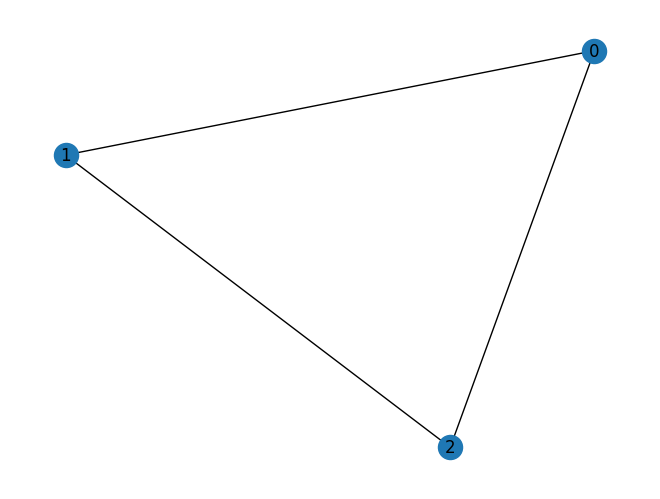

In [58]:
# Parametri
n_nodes = 3
k_colors = 3
edges = [(0, 1), (1, 2), (2, 0)]
graph = nx.Graph(edges)
positions = nx.spring_layout(graph, seed=1)
nx.draw(graph, with_labels=True, pos=positions)
plt.show()

In [59]:
m = int(np.ceil(np.log2(k_colors)))  # qubits per nodo
n_qubits = n_nodes * m
wires = list(range(n_qubits))

# Qubit per nodo
def qubits_for_node(v):
    return [v * m + i for i in range(m)]


In [60]:
# Hamiltoniano di costo
cost_h = qml.Hamiltonian([], [])  # inizializzazione esplicita

# --- Penalità: nodi adiacenti con stesso colore ---
for (u, v) in edges:
    terms = []
    for i in range(m):
        op = (qml.PauliZ(qubits_for_node(u)[i]) @ qml.PauliZ(qubits_for_node(v)[i]))
        terms.append((1 + op) / 2)

    # Prodotto dei termini
    penalty = reduce(operator.matmul, terms)
    cost_h += penalty

# --- Penalità: codifiche non valide (se k < 2^m) ---
invalid_bitstrings = [b for b in product([0, 1], repeat=m) if int("".join(map(str, b)), 2) >= k_colors]

for v in range(n_nodes):
    q_v = qubits_for_node(v)
    for b in invalid_bitstrings:
        proj_terms = []
        for i in range(m):
            z = qml.PauliZ(q_v[i])
            coeff = (-1)**b[i]
            proj_terms.append((1 + coeff * z) / 2)

        proj = reduce(operator.matmul, proj_terms)
        cost_h += proj


In [61]:
# Mixer Hamiltonian
mixer_h = qml.Hamiltonian([], [])
for w in wires:
    mixer_h += qml.PauliX(w)

In [62]:
# QAOA layer
def qaoa_layer(gamma, alpha):
    qml.ApproxTimeEvolution(cost_h, gamma, 1)
    qml.ApproxTimeEvolution(mixer_h, alpha, 1)


In [63]:
# Circuito
depth = 2
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [64]:
# Device
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [65]:
# Ottimizzazione
optimizer = qml.AdamOptimizer()
steps = 100
params = np.array([[0.5] * depth, [0.5] * depth], requires_grad=True)

patience = 3           
min_delta = 0.01        
counter = 0
cost_history = []
best_cost = np.inf
best_params = None

for step in tqdm(range(steps), desc="Training Progress"):
    cost = cost_function(params)
    cost_history.append(cost)

    # Early stopping logic
    if best_cost - cost > min_delta:
        best_cost = cost
        best_params = params.copy()
        counter = 0
    else:
        counter += 1

    # Check stop condition
    if counter >= patience:
        print(f"Early stopping at step {step}")
        break

    params = optimizer.step(cost_function, params)

print("Miglior costo trovato:", best_cost)
print("Parametri corrispondenti:", best_params)

Training Progress:  92%|█████████▏| 92/100 [00:08<00:00, 10.55it/s]

Early stopping at step 92
Miglior costo trovato: 0.9798253495068363
Parametri corrispondenti: [[ 0.61104852 -0.19529611]
 [ 0.64515854  0.71027508]]


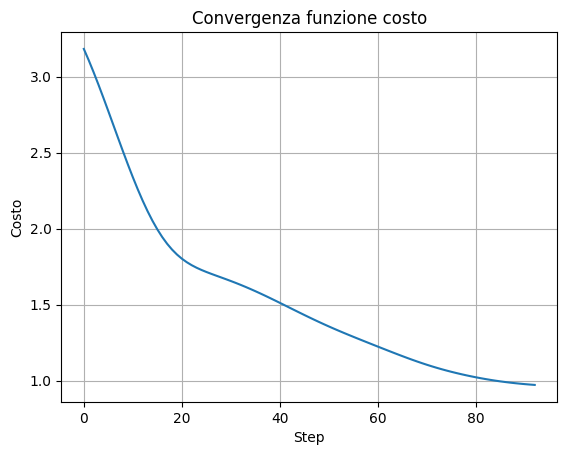

In [66]:
# Plot convergenza
plt.plot(cost_history)
plt.title("Convergenza funzione costo")
plt.xlabel("Step")
plt.ylabel("Costo")
plt.grid(True)
plt.show()

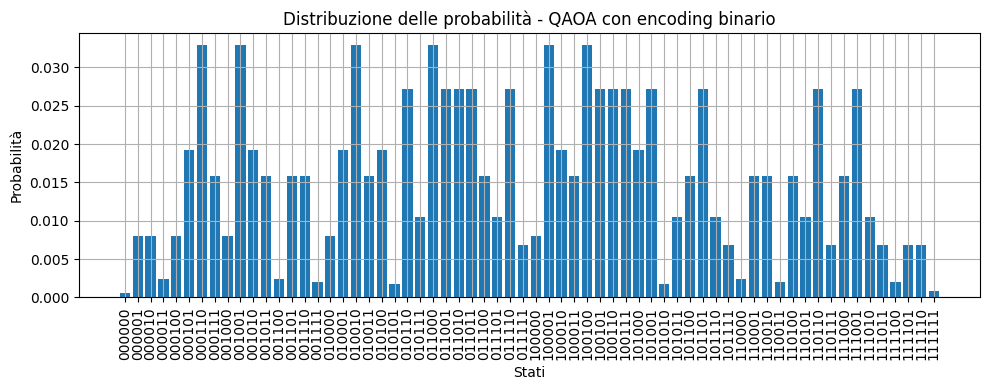

In [67]:
# Probabilità finali
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(best_params[0], best_params[1])

# Istogramma
bitstrings = [format(i, f"0{n_qubits}b") for i in range(2**n_qubits)]

plt.figure(figsize=(10, 4))
plt.bar(bitstrings, probs)
plt.xticks(rotation=90)
plt.xlabel("Stati")
plt.ylabel("Probabilità")
plt.title("Distribuzione delle probabilità - QAOA con encoding binario")
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
# Analisi risultati
def decode_binary(bitstring, m):
    return int(bitstring, 2)

def analyze_binary_results(probs, n_nodes, m, k_colors, edges, threshold=None):
    if threshold is None:
        threshold = max(probs) - 1e-4

    print("Bitstring | Assegnamento | Valido | Probabilità")
    print("-" * 50)
    deg = 0
    outcome = False
    best_assignment = None

    for i, p in enumerate(probs):
        if p < threshold:
            continue

        bitstring = format(i, f"0{n_nodes * m}b")
        assignment = {}
        valid = True

        for v in range(n_nodes):
            bits = bitstring[v * m:(v + 1) * m]
            color = decode_binary(bits, m)
            assignment[v] = color
            if color >= k_colors:
                valid = False

        for u, v in edges:
            if assignment[u] == assignment[v]:
                valid = False

        print(f"{bitstring} | {assignment} | {valid} | {p:.4f}")
        if valid:
            deg += 1
            best_assignment = assignment
            outcome = True

    return best_assignment, outcome, deg

assignment, outcome, deg = analyze_binary_results(probs, n_nodes, m, k_colors, edges)

Bitstring | Assegnamento | Valido | Probabilità
--------------------------------------------------
000110 | {0: 0, 1: 1, 2: 2} | True | 0.0329
001001 | {0: 0, 1: 2, 2: 1} | True | 0.0329
010010 | {0: 1, 1: 0, 2: 2} | True | 0.0329
011000 | {0: 1, 1: 2, 2: 0} | True | 0.0329
100001 | {0: 2, 1: 0, 2: 1} | True | 0.0329
100100 | {0: 2, 1: 1, 2: 0} | True | 0.0329


In [69]:
#Output: numero cromatico
if outcome:
    print(f"Il numero minimo di colori per colorare il grafo è {k_colors} e si può fare in {deg} modi diversi")
else:
    print(f"{k_colors} NON è il numero cromatico del grafo")

Il numero minimo di colori per colorare il grafo è 3 e si può fare in 6 modi diversi


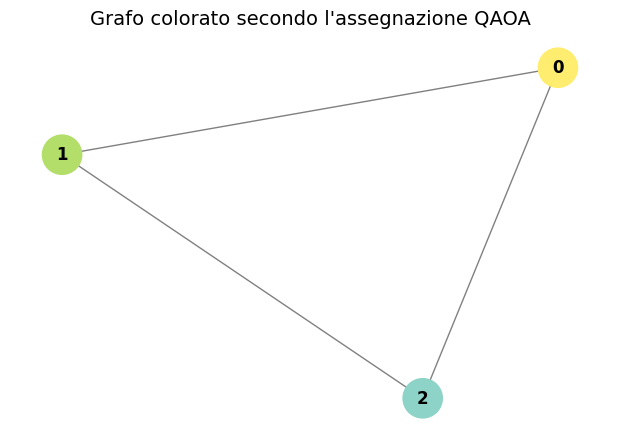

In [70]:
# Visualizzazione grafo colorato
def plot_colored_graph(graph, assignment, positions=None, cmap=plt.cm.Set3):
    node_colors = [assignment[n] for n in graph.nodes]
    unique_colors = sorted(set(node_colors))
    n_colors = len(unique_colors)
    color_list = [cmap(i / max(1, n_colors - 1)) for i in range(n_colors)]
    color_map = {c: color_list[i] for i, c in enumerate(unique_colors)}
    final_colors = [color_map[c] for c in node_colors]

    if positions is None:
        positions = nx.spring_layout(graph, seed=42)

    plt.figure(figsize=(6, 4))
    nx.draw(
        graph,
        pos=positions,
        with_labels=True,
        node_color=final_colors,
        edge_color="gray",
        node_size=800,
        font_color="black",
        font_weight="bold"
    )
    plt.title("Grafo colorato secondo l'assegnazione QAOA", fontsize=14)
    plt.axis('off')
    plt.show()

if assignment:
    plot_colored_graph(graph, assignment, positions)